In [ ]:
# bsisoをlead timeをずらして予測させるモデル
!pip install cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 54.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
from numpy.linalg.linalg import norm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, LayerNormalization
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.regularizers import l2
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.markers import MarkerStyle
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd


# データの読み込み
data = np.load('/content/drive/MyDrive/bsiso_cnn/olr_1979-2022_mjjaaso_clim-norm.npz')
df1 = np.load('/content/drive/MyDrive/bsiso_cnn/olr_lanczosbp.npz')
df2 = np.load('/content/drive/MyDrive/bsiso_cnn/lanczosbp_w850.npz')

2024-03-28 13:27:35.527484: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-28 13:27:35.531854: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-28 13:27:35.584263: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-28 13:27:36.325927: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


ModuleNotFoundError: No module named 'cartopy'

## ●data import

In [ ]:
print(df1.files)
lat = df1['lat']
lon = df1['lon']
olr = df1['bandpass_olr_jja'][80:-435,:,:]
time = df1['time'][80:-435]
real_time = pd.to_datetime(time, unit='h', origin=pd.Timestamp('1800-01-01')) # 時刻をdatetime型に変換
print(lat.shape, lon.shape, olr.shape, time.shape, real_time.shape)
print(real_time[0], real_time[-1])

['lat', 'lon', 'bandpass_olr_jja', 'time']
(25,) (144,) (15556, 25, 144) (15556,) (15556,)
1979-03-22 00:00:00 2021-10-22 00:00:00


In [ ]:
print(df2.files)
u850 = df2['u_850'][80:-739,24:49,:]
v850 = df2['v850'][80:-739,24:49,:]
time_w = df2['time'][80:-739]
real_time_w = pd.to_datetime(time_w, unit='h', origin=pd.Timestamp('1800-01-01'))
print(u850.shape, v850.shape)
print(real_time_w[0], real_time_w[-1])

['lat', 'lon', 'u_850', 'v850', 'time']
(15556, 25, 144) (15556, 25, 144)
1979-03-22 00:00:00 2021-10-22 00:00:00


## ● 前処理

In [ ]:
# 標準化処理
def normalization(data):
  data_mean = np.mean(data, axis=0)
  data_std  = np.std(data, axis=0)
  data_norm = (data - data_mean) / data_std
  print('Raw Data        = ', data.max(), data.min())
  print('Normalized Data = ', data_norm.max(), data_norm.min())
  del data_mean, data_std
  return data_norm

olr_norm = normalization(olr)
u850_norm = normalization(u850)
v850_norm = normalization(v850)

Raw Data        =  88.62386484718627 -94.22794849334653
Normalized Data =  8.574507123296414 -11.833077855088446
Raw Data        =  35.832287 -34.265118
Normalized Data =  7.8160696 -7.1379857
Raw Data        =  32.986057 -30.925972
Normalized Data =  11.765218 -10.446436


In [ ]:
# bsiso index (eEOF) 読み込み
data_file = '/content/drive/MyDrive/bsiso_cnn/bsiso_filterd_index.dat'

year    = np.loadtxt(data_file, usecols = 0, dtype = int)
month   = np.loadtxt(data_file, usecols = 1, dtype = int)
day     = np.loadtxt(data_file, usecols = 2, dtype = int)
PC     = np.loadtxt(data_file, usecols = [3, 4])
#PCy     = np.loadtxt(data_file, usecols = 4)
phase   = np.loadtxt(data_file, usecols = 5, dtype = int)
Amp_nrm_bsiso = np.loadtxt(data_file, usecols = 6, dtype = float)
#index = np.loadtxt(data_file)

print('month = ', month.shape)
print('phase = ', phase.shape)
print( 'PC = ', PC.shape)
print('Amp_nrm_bsiso = ', Amp_nrm_bsiso.shape)
print(year, month, day)

month =  (15556,)
phase =  (15556,)
PC =  (15556, 2)
Amp_nrm_bsiso =  (15556,)
[1979 1979 1979 ... 2021 2021 2021] [ 3  3  3 ... 10 10 10] [22 23 24 ... 20 21 22]


In [ ]:
# 全て一律にずらしたあと、インデクシングする
lead_time = 0
multi_forcast = False
if multi_forcast == True:
  output_shape = 2 * (lead_time + 1)
else:
  output_shape = 2
print('output shape = ', output_shape)

amp = Amp_nrm_bsiso[10:-lead_time-1]
ph = phase[10:-lead_time-1]
yy = year[10:-lead_time-1]
mm = month[10:-lead_time-1]
dd = day[10:-lead_time-1]
rt = real_time[10:-lead_time-1]
# 教師データは前進させる
if multi_forcast == True:
  sup_data = []
  for j in range(lead_time+1):
    sup_j = PC[10+j:-lead_time-1+j]
    sup_data.append(sup_j)
  sup_data = np.array(sup_data).transpose(1,0,2).reshape(-1, output_shape)
else:
  sup_data = PC[10+lead_time:]
print(sup_data.shape)


# 入力データの前処理
def preprocess(data):
  ipt_lag0  = data[10:-lead_time-1]
  ipt_lag5  = data[5:-lead_time-6]
  ipt_lag10 = data[:-lead_time-11]

  # =========
  # 訓練データの作成
  idx = np.where((mm >= 5) & (mm <= 10) & (yy <= 2014))[0]
  ipt_lag0_train = ipt_lag0[idx]
  ipt_lag5_train = ipt_lag5[idx]
  ipt_lag10_train = ipt_lag10[idx]
  #ipt_train = np.concatenate([ipt_lag0_train, ipt_lag5_train, ipt_lag10_train], 1)
  ipt_train = np.stack([ipt_lag0_train, ipt_lag5_train, ipt_lag10_train], 3)

  # 検証データの作成
  idx = np.where((mm >= 5) & (mm <= 10) & (yy > 2014))[0]
  ipt_lag0_test = ipt_lag0[idx]
  ipt_lag5_test = ipt_lag5[idx]
  ipt_lag10_test = ipt_lag10[idx]
  #ipt_test = np.concatenate([ipt_lag0_test, ipt_lag5_test, ipt_lag10_test], 1)
  ipt_test = np.stack([ipt_lag0_test, ipt_lag5_test, ipt_lag10_test], 3)
  return ipt_train, ipt_test

olr_ipt_train, olr_ipt_test = preprocess(olr_norm)
u850_ipt_train, u850_ipt_test = preprocess(u850_norm)
v850_ipt_train, v850_ipt_test = preprocess(v850_norm)
ipt_train = np.concatenate([olr_ipt_train, u850_ipt_train, v850_ipt_train], 3)
ipt_test = np.concatenate([olr_ipt_test, u850_ipt_test, v850_ipt_test], 3)
#ipt_train, ipt_test = v850_ipt_train, v850_ipt_test

# その他のインデクシング
idx = np.where((mm >= 5) & (mm <= 10) & (yy <= 2014))[0]
sup_train = sup_data[idx]
idx = np.where((mm >= 5) & (mm <= 10) & (yy > 2014))[0]
sup_test = sup_data[idx]
amp = amp[idx]
ph = ph[idx]
yy = yy[idx]
mm = mm[idx]
dd = dd[idx]
rt = rt[idx]
print(sup_test.shape, ipt_test.shape, ipt_train.shape, ph.shape, yy.shape, mm.shape, dd.shape)
del olr_ipt_train, olr_ipt_test, u850_ipt_train, u850_ipt_test, v850_ipt_train, v850_ipt_test

output shape =  2
(15546, 2)
(1278, 2) (1278, 25, 144, 9) (6624, 25, 144, 9) (1278,) (1278,) (1278,) (1278,)


In [ ]:
# !!! メモリ解放のため、必要に応じて保持している変数を削除 !!!
del olr, u850, v850

#### ResNet の試用

In [ ]:
#とりあえずTensorFlowの呼出し
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as layers


#Residual Blockの定義
def residual_block(inputs, ch, strides):
    # main path
    #（Batch Normalization ⇒　ReLU　⇒　畳み込み）×２セット
    x = layers.BatchNormalization()(inputs)
    x = layers.ReLU()(x)
    x = layers.Conv2D(ch, 3, strides=strides, padding="same",
                      kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x) # Conv2Dに1e-4のL2正則化を入れます（論文より）
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(ch, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)

    # shortcut path
    # inputデータ（2層畳み込む前のデータ）を呼び出す
    if inputs.shape[-1] != ch or strides > 1:
        s = layers.Conv2D(ch, 3, strides=strides, padding="same",
                          kernel_regularizer=tf.keras.regularizers.l2(1e-4))(inputs)
    else:
        s = inputs

    # add
    # inputデータと2層畳み込んだデータを足す
    x = layers.Add()([x, s])
    return x


#ResNetモデルの作成
def create_resnet():
    # inputは（縦pixel, 横pixel, チャンネル数)なので入力画像へあった形へ調整
    inputs = layers.Input((25, 144, 9))
    # ResNet論文に合わせ畳み込みカーネル（フィルタ）数を16, 32, 64に設定。最初の層で16に設定
    x = layers.Conv2D(16, 3, padding="same")(inputs)
    # フィルタ数を増やしながらモデルを作成する。リストの中身がフィルタ数。
    for ch in [16, 32, 64]:
    # SkipConnectionを何回入れるか設定。今回は7回に設定。
        for i in range(7):
            # stridesの設定
            strides = 2 if i == 0 else 1
            if ch == 16:
                strides = 1
            # 上で定義したresidual blockの呼出し
            x = residual_block(x, ch, strides)
    # 最後にBatch Normalization ⇒　ReLU　⇒　プーリング層　⇒　全結合層を設定しモデル完成
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    # pooling層を追加。
    x = layers.GlobalAveragePooling2D()(x)
    # 全結合層を追加。活性化関数は分類問題の場合softmax
    x = layers.Dense(output_shape, activation="linear")(x)

    return tf.keras.models.Model(inputs, x)

In [ ]:
model = create_resnet()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 25, 144, 9)]         0         []                            
                                                                                                  
 conv2d_90 (Conv2D)          (None, 25, 144, 16)          1312      ['input_3[0][0]']             
                                                                                                  
 batch_normalization_86 (Ba  (None, 25, 144, 16)          64        ['conv2d_90[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 re_lu_86 (ReLU)             (None, 25, 144, 16)          0         ['batch_normalization_86

### CNN モデル

In [ ]:
# CNNモデルの構築
model = Sequential()
# 入力画像　25×144×3 ：(緯度方向の格子点数)×(軽度方向の格子点数)×(チャンネル数、OLRのラグ)
model.add(Conv2D(16, (3, 3), padding='same', input_shape=(25, 144, 9), strides=(2,2), ))   # ゼロパディング、バッチサイズ以外の画像の形状を指定 25*144*1 -> 25*144*8
model.add(LayerNormalization())
model.add(Activation('relu'))                                             # 活性化関数
#model.add(MaxPooling2D(pool_size=(2, 2)))                                 # 21*140*16 -> 10*70*16
model.add(Conv2D(32, (3, 3), padding='same', strides=(2,2)))                                             # 25*144*8 -> 21*140*16
model.add(LayerNormalization())
model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))                                 # 21*140*16 -> 10*70*16

model.add(Conv2D(64, (2, 2), padding='same', strides=(2,2)))                             # 10*70*16 -> 10*70*32
model.add(LayerNormalization())
model.add(Activation('relu'))

#model.add(MaxPooling2D(pool_size=(2, 2)))                                 # 10*70*32 -> 5*35*32
#model.add(MaxPooling2D(pool_size=(2, 2)))                                 # 3*33*64 -> 1*16*64
model.add(Dropout(0.2))  # ドロップアウト

model.add(Flatten())  # 一次元の配列に変換                                # 1*16*64 -> 1024
model.add(Dense(256))
#model.add(Activation('relu'))
#model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(output_shape, activation='linear'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 13, 72, 16)        1312      
                                                                 
 layer_normalization_3 (Lay  (None, 13, 72, 16)        32        
 erNormalization)                                                
                                                                 
 activation_12 (Activation)  (None, 13, 72, 16)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 7, 36, 32)         4640      
                                                                 
 layer_normalization_4 (Lay  (None, 7, 36, 32)         64        
 erNormalization)                                                
                                                                 
 activation_13 (Activation)  (None, 7, 36, 32)        

In [ ]:
# モデルのコンパイルと学習の設定
# !!! acuracy = 0.20を目指す !!!
model.compile(optimizer=Adam(),
              loss='mean_squared_error',  # MSE
              )
# モデルのトレーニング
history = model.fit(ipt_train, sup_train, epochs=100, batch_size=128, validation_data=(ipt_test, sup_test))

Epoch 1/100
52/52 [==============================] - 5s 50ms/step - loss: 4.0811 - val_loss: 0.5358
Epoch 2/100
52/52 [==============================] - 2s 31ms/step - loss: 0.5665 - val_loss: 0.4653
Epoch 3/100
52/52 [==============================] - 2s 31ms/step - loss: 0.4814 - val_loss: 0.2469
Epoch 4/100
52/52 [==============================] - 2s 37ms/step - loss: 0.1047 - val_loss: 0.0623
Epoch 5/100
52/52 [==============================] - 2s 38ms/step - loss: 0.0496 - val_loss: 0.0551
Epoch 6/100
52/52 [==============================] - 2s 31ms/step - loss: 0.0414 - val_loss: 0.0499
Epoch 7/100
52/52 [==============================] - 2s 31ms/step - loss: 0.0349 - val_loss: 0.0500
Epoch 8/100
52/52 [==============================] - 2s 34ms/step - loss: 0.0332 - val_loss: 0.0521
Epoch 9/100
52/52 [==============================] - 2s 31ms/step - loss: 0.0285 - val_loss: 0.0472
Epoch 10/100
52/52 [==============================] - 2s 31ms/step - loss: 0.0268 - val_loss: 0.0440

In [ ]:
# モデルの出力を獲得する
predict = model.predict(ipt_test, batch_size=None, verbose=0, steps=None)
print(predict.shape)
y_test = sup_test
np.savez('/content/drive/MyDrive/bsiso_cnn/v4_results/no_batch_norm_predict_' + str(lead_time) + 'day.npz', predict, y_test)

(1278, 2)


In [ ]:
# モデルの保存
model.save('/content/drive/MyDrive/bsiso_cnn/v4_results/no_batch_norm_predict_' + str(lead_time) + 'day.hdf5')

In [ ]:
# テストデータセットの保存
np.savez('/content/drive/MyDrive/bsiso_cnn/results/test_data_sets.npz',rt=rt, dd=dd, mm=mm, yy=yy, ph=ph, amp=amp)

In [ ]:
# prediction skill をリードタイムごとに出す
# Forcast skill evaluation(COR)

cor = []
for j in range(lead_time+1):
  cor_j = (np.sum(predict[:,2*j] * y_test[:,2*j], axis=0) + np.sum(predict[:,2*j+1] * y_test[:,2*j+1], axis=0)) / \
            (np.sqrt(np.sum(predict[:,2*j] ** 2 + predict[:,2*j+1] ** 2, axis=0)) * np.sqrt(np.sum(y_test[:,2*j] ** 2 + y_test[:,2*j+1] ** 2, axis=0)))
  print('{} = '.format(j), cor_j)
  cor.append(cor_j)
cor = np.array(cor)
np.savez('/content/drive/MyDrive/bsiso_cnn/shap_analysis/no_batch_norm_olr-u-v.npz', cor)

0 =  0.9873019624680874


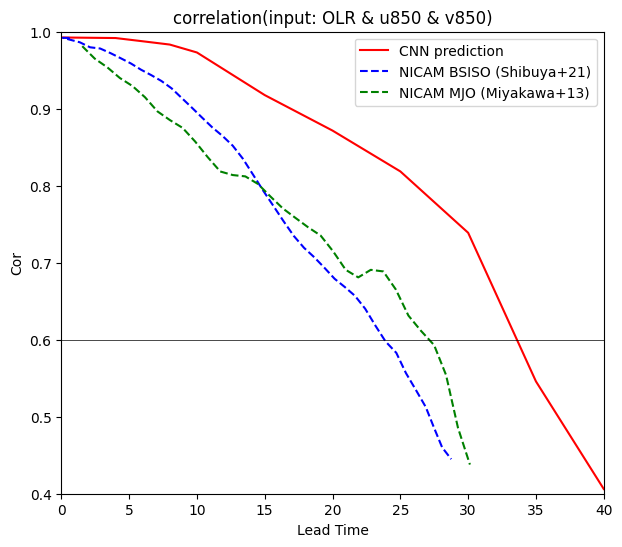

In [ ]:
# cor の評価
# 確率的にばらつくため、1σで適当に幅を評価すると良いと考えられる。

# 先行研究の結果：Shibuya et al., 2021
# 2000-2014年の8月におけるNACAMによる全球シミュレーション、解像度は水平14km
# 相関係数が0.6以上のリードタイムを"prediction skill" とすると24日間
nicam_bsiso = np.array([
    [0.6145144, 0.9919250],
    [0.1220745, 0.9920530],
    [1.3663927, 0.9862836],
    [2.1182138, 0.9798000],
    [2.8703655, 0.9781713],
    [3.6222251, 0.9722551],
    [4.3740378, 0.9656494],
    [5.1258372, 0.9588480],
    [5.8775442, 0.9506906],
    [6.6293278, 0.9436571],
    [7.3810713, 0.9360362],
    [8.1326835, 0.9264866],
    [8.8840872, 0.9138771],
    [9.6354934, 0.9013038],
    [10.3868744, 0.888360],
    [11.1382741, 0.875693],
    [11.8897835, 0.864635],
    [12.6411853, 0.8519968],
    [13.3922926, 0.8350366],
    [14.1431426, 0.8142987],
    [14.8939842, 0.7934375],
    [15.6448970, 0.7736204],
    [16.3958043, 0.7537236],
    [17.1467724, 0.7347187],
    [17.8979889, 0.7193610],
    [18.6494207, 0.7071647],
    [19.4007518, 0.6934893],
    [20.1520385, 0.6791613],
    [20.9035726, 0.6684660],
    [21.6550534, 0.6569876],
    [22.4061780, 0.6402813],
    [23.1569510, 0.6184123],
    [23.9078067, 0.5977576],
    [24.7032303, 0.5829329],
    [25.4095400, 0.5567711],
    [26.1602745, 0.5343365],
    [26.8743596, 0.5125842],
    [27.4597305, 0.4867337],
    [28.0817463, 0.4601367],
    [28.7504060, 0.4449050]
])

# MJO skill scores of NICAM (Miyakawa+13)
# 2008-2012年の各１１月～３月の結果
# 水平解像度は１４km
nicam_mjo = np.array([
    [1.5462208206076005, 0.9812175237750825],
    [2.471175961112099, 0.9650189502864384],
    [3.3961311016165974, 0.9537185887268789],
    [4.321086242121097, 0.9398692413707002],
    [5.246041382625594, 0.9295024036275322],
    [6.170996523130094, 0.9149337246728477],
    [7.095951663634593, 0.8964731763992999],
    [8.020906804139091, 0.8851075403353617],
    [8.945861944643589, 0.8751195571276585],
    [9.870817085148087, 0.8573822766036338],
    [10.795772225652588, 0.8371307796169803],
    [11.720727366157085, 0.8184980247364029],
    [12.645682506661583, 0.81384844634661],
    [13.570637647166084, 0.8121263802763163],
    [14.495592787670581, 0.8023794863184543],
    [15.420547928175079, 0.7860198586506645],
    [16.34550306867958, 0.7703834987323981],
    [17.270458209184078, 0.7581568296333131],
    [18.195413349688575, 0.7461023671412574],
    [19.120368490193073, 0.7353222335412192],
    [20.045323630697574, 0.714760764661913],
    [20.97027877120207, 0.6907896049634251],
    [21.89523391170657, 0.6809566077020484],
    [22.82018905221107, 0.6907617259437944],
    [23.745144192715568, 0.6886890144203301],
    [24.670099333220065, 0.6651652618374555],
    [25.595054473724563, 0.6313622529216377],
    [26.520009614229064, 0.6115917863906195],
    [27.490868235651895, 0.592994267631173],
    [28.369919895238063, 0.5541756981814071],
    [29.25011914184718, 0.4856055535449536],
    [30.130318388456303, 0.43786084747740284],
])

cnn_nodel = np.array([
    [0,  0.9925489267970012],
    [2,  0.9921619014788010],
    [4,  0.9917982369942809],
    [6,  0.9876011011358417],
    [8,  0.9833260673707259],
    [10, 0.9730582619096018],
    [15, 0.9177067088356041],
    [20, 0.8716005416467286],
    [25, 0.8185876235392283],
    [30, 0.7388985175180534],
    [35, 0.5458392483160485],
    [40, 0.4060880564285142]

])
j = np.arange(0,lead_time+1)
fig = plt.figure(figsize=(7,6))
#plt.plot(j, cor, linestyle='solid', color='r', label='CNN prediction')
plt.plot(cnn_nodel[:,0], cnn_nodel[:,1], linestyle='solid', color='r', label='CNN prediction')
plt.plot(nicam_bsiso[:,0], nicam_bsiso[:,1], linestyle='dashed', color='b', label='NICAM BSISO (Shibuya+21)')
plt.plot(nicam_mjo[:,0], nicam_mjo[:,1], linestyle='dashed', color='g', label='NICAM MJO (Miyakawa+13)')
plt.hlines(0.6, 0, 50, color='k', linewidth=.5)
plt.xlim(0,lead_time)
plt.ylim(0.4,1)
plt.title('correlation(input: OLR & u850 & v850)')
plt.xlabel('Lead Time')
plt.ylabel('Cor')
plt.savefig('/content/drive/MyDrive/bsiso_cnn/results/cor_evaluation_v850.png', dpi=300)
plt.legend()
plt.show()

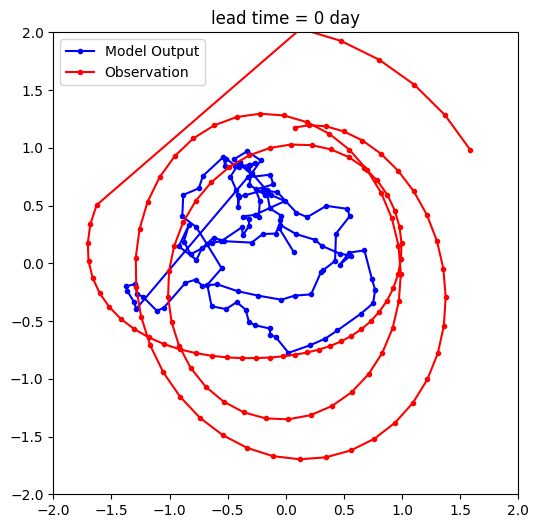

In [ ]:
#start = 30 - lead_time
#stop  = 91 - lead_time
time_lag = 0
start = 730
stop  = 850
fig = plt.figure(figsize=(6,6))
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.plot(predict[start:stop,2*time_lag], predict[start:stop,2*time_lag+1], label='Model Output', linestyle='solid', color='b', marker='.')
plt.plot(y_test[start:stop,2*time_lag], y_test[start:stop,2*time_lag+1], label='Observation', linestyle='solid', color='r', marker='.')
plt.title('lead time = ' + str(time_lag) + ' day')
#plt.scatter(predict[0:100,0], predict[0:100,1], color='b')
plt.legend()
plt.savefig('/content/drive/MyDrive/bsiso_cnn/results/3channel_plot_result.png', dpi=300)
plt.show()

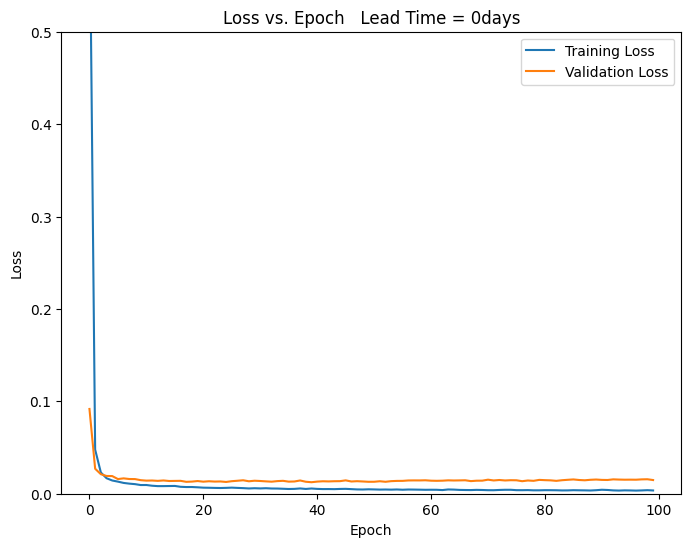

In [ ]:
# 学習の履歴をプロット
plt.figure(figsize=(8, 6))

# 損失（loss）をプロット
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')    #Validation loss : 精度検証データにおける損失
plt.ylim(0, 0.5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch   Lead Time = ' + str(lead_time) + 'days')
plt.legend()

# 表示
plt.show()

[[1.         0.97513708]
 [0.97513708 1.        ]]


<ipython-input-288-8e3c12494ebb>:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(predict[:,0], y_test[:,0], cmap='seismic', label='data')


[[1.         0.97905711]
 [0.97905711 1.        ]]


<ipython-input-288-8e3c12494ebb>:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(predict[:,1], y_test[:,1], cmap='seismic', label='data')


<Figure size 1000x1200 with 0 Axes>

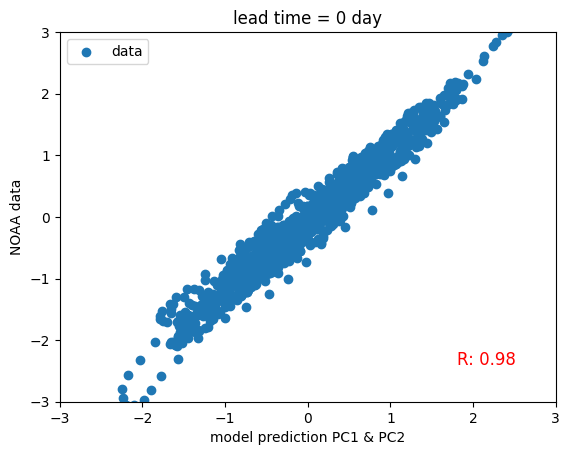

<Figure size 1200x1200 with 0 Axes>

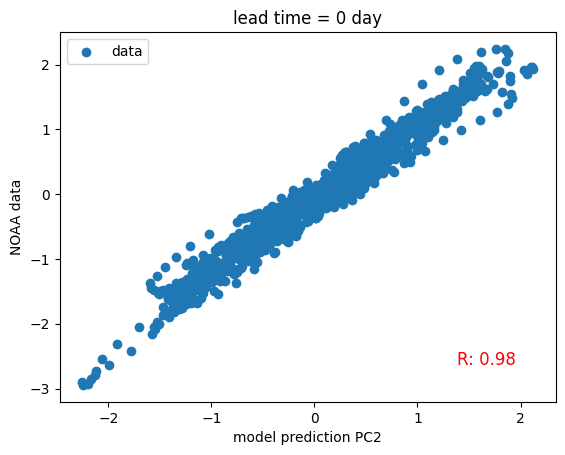

In [ ]:
# 観測データとモデル出力との相関係数を計算する
# PC1

cor = np.corrcoef(predict[:,0], y_test[:,0], rowvar=True)
print(cor)
R = '{:.2f}'.format(cor[0,1])
fig = plt.figure(figsize=(10,12))
fig, ax = plt.subplots(1,1)
ax.scatter(predict[:,0], y_test[:,0], cmap='seismic', label='data')
plt.xlim(-3,3)
plt.ylim(-3,3)
ax.set_xlabel('model prediction PC1 & PC2')
ax.set_ylabel('NOAA data')
plt.title('lead time = 0 day')
plt.text(0.8, 0.1, f'R: ' + str(R), transform=plt.gca().transAxes, fontsize=12, color='red')
ax.legend()
plt.savefig('/content/drive/MyDrive/bsiso_cnn/results/3channel_pc1_leadtime_' + str(lead_time) + 'day.png', dpi=300)

# PC2の場合
cor = np.corrcoef(predict[:,1], y_test[:,1], rowvar=True)
print(cor)
R = '{:.2f}'.format(cor[0,1])
fig = plt.figure(figsize=(12,12))
fig, ax = plt.subplots(1,1)
ax.scatter(predict[:,1], y_test[:,1], cmap='seismic', label='data')
ax.set_xlabel('model prediction PC2')
ax.set_ylabel('NOAA data')
plt.title('lead time = 0 day')
plt.text(0.8, 0.1, f'R: ' + str(R), transform=plt.gca().transAxes, fontsize=12, color='red')
ax.legend()
plt.savefig('/content/drive/MyDrive/bsiso_cnn/results/3_channel_pc2_leadtime_' + str(lead_time) + 'day.png', dpi=300)

# 時系列の精度比較

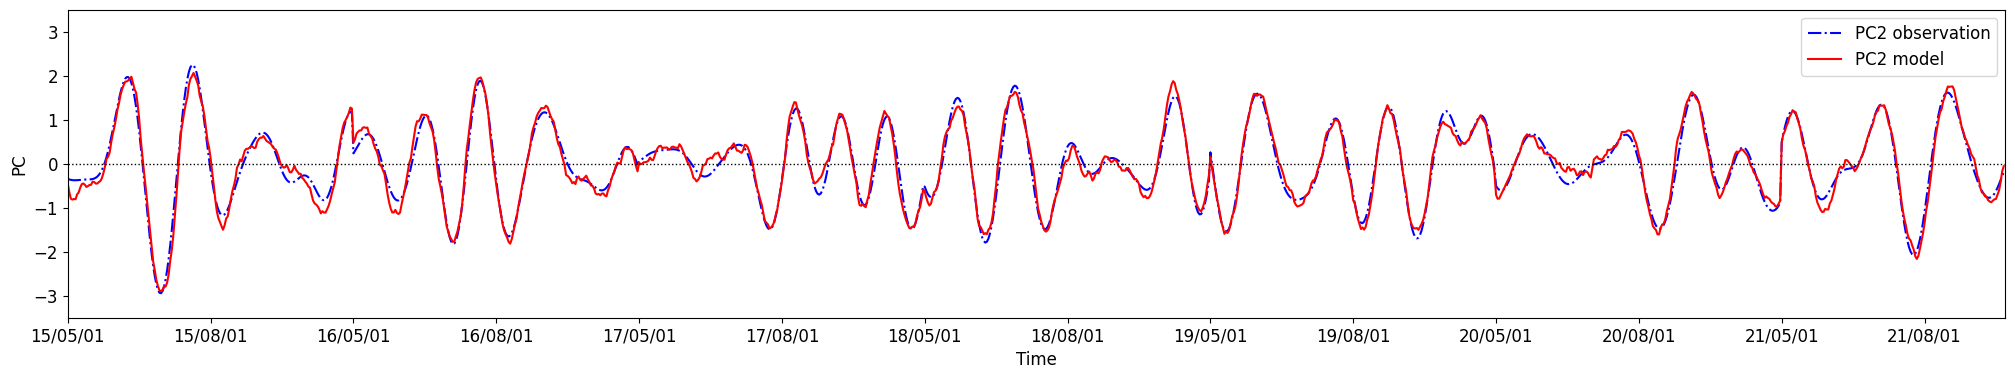

In [ ]:
# 時系列プロット
fig = plt.figure(figsize=(25, 4))
ax = fig.add_subplot(111)
ax.plot(rt.strftime('%y/%m/%d'), y_test[:,1], label='PC2 observation', color='b', linestyle='-.')
ax.plot(rt.strftime('%y/%m/%d'), predict[:,1],    label='PC2 model', color='r', linestyle='solid')
ax.tick_params(labelsize=12)
plt.hlines(0, 0, predict.shape[0], color='k', linewidth=1.0, linestyle=':')
ax.legend(fontsize=12)
# 振幅が1以上の領域を塗りつぶす
#ax.fill_between(real_time[st+10:10+num], -4, 4, where=(np.abs(pc1_norm[st:num])>1) | (np.abs(pc2_norm[st:num])>1), facecolor='k', alpha=0.2)
ax.set_ylim(-3.5, 3.5)
ax.set_xlim(0, 1248)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('PC', fontsize=12)
plt.xticks(np.arange(0, predict.shape[0], 92))    # x軸の目盛りは１年刻み
ax.legend(fontsize=12)
plt.show()


#● Grad-CAM による判断根拠の可視化

In [ ]:
import numpy as np
import cv2

# 画像用
from keras.preprocessing.image import array_to_img, img_to_array, load_img
# モデル読み込み用
from keras.models import load_model
# Grad−CAM計算用
from tensorflow.keras import models
import tensorflow as tf

In [ ]:

def grad_cam(input_model, x, layer_name):
    """
    Args:
        input_model(object): モデルオブジェクト
        x(ndarray): 画像
        layer_name(string): 畳み込み層の名前
    Returns:
        output_image(ndarray): 元の画像に色付けした画像
    """

    # 画像の前処理
    # 読み込む画像が1枚なため、次元を増やしておかないとmode.predictが出来ない
    X = np.expand_dims(x, axis=0)
    preprocessed_input = X.astype('float32')
    IMAGE_SIZE = (25, 144, 3)
    grad_model = models.Model([input_model.inputs], [input_model.get_layer(layer_name).output, input_model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(preprocessed_input)
        class_idx = np.argmax(predictions[0])
        loss = predictions[:, class_idx]

    # 勾配を計算
    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')

    guided_grads = gate_f * gate_r * grads

    # 重みを平均化して、レイヤーの出力に乗じる
    weights = np.mean(guided_grads, axis=(0, 1))
    cam = np.dot(output, weights)
    #print(cam.shape)
    # 画像を元画像と同じ大きさにスケーリング
    cam = cv2.resize(cam, (x.shape[1], x.shape[0]), cv2.INTER_LINEAR)
    # ReLUの代わり
    cam  = np.maximum(cam, 0)
    # ヒートマップを計算(規格化はしない)
    eps = 1e-5
    heatmap = cam / (np.max(cam)+ eps)
    ## モノクロ画像に疑似的に色をつける
    #jet_cam = cv2.applyColorMap(np.uint8(255.0*heatmap), cv2.COLORMAP_JET)
    ## RGBに変換
    #rgb_cam = cv2.cvtColor(jet_cam, cv2.COLOR_BGR2RGB)
    ## もとの画像に合成
    #output_image = (np.float32(rgb_cam) + x / 2)

    return heatmap

In [ ]:
# !!! ランタイムが切れていた場合は以下から読み込み
model_path = '/content/drive/MyDrive/bsiso_cnn/1channel_3lag_cnn_model.hdf5'
model = load_model(model_path)
#x = img_to_array(load_img(image_path, target_size=IMAGE_SIZE))

In [ ]:
num = 618
x_image = x_test[num,:,:,:]
print(x_image.shape)
target_layer = 'activation_1'
#target_layer = 'conv2d'
output_img = grad_cam(model, x_image, target_layer)

(75, 144, 1)


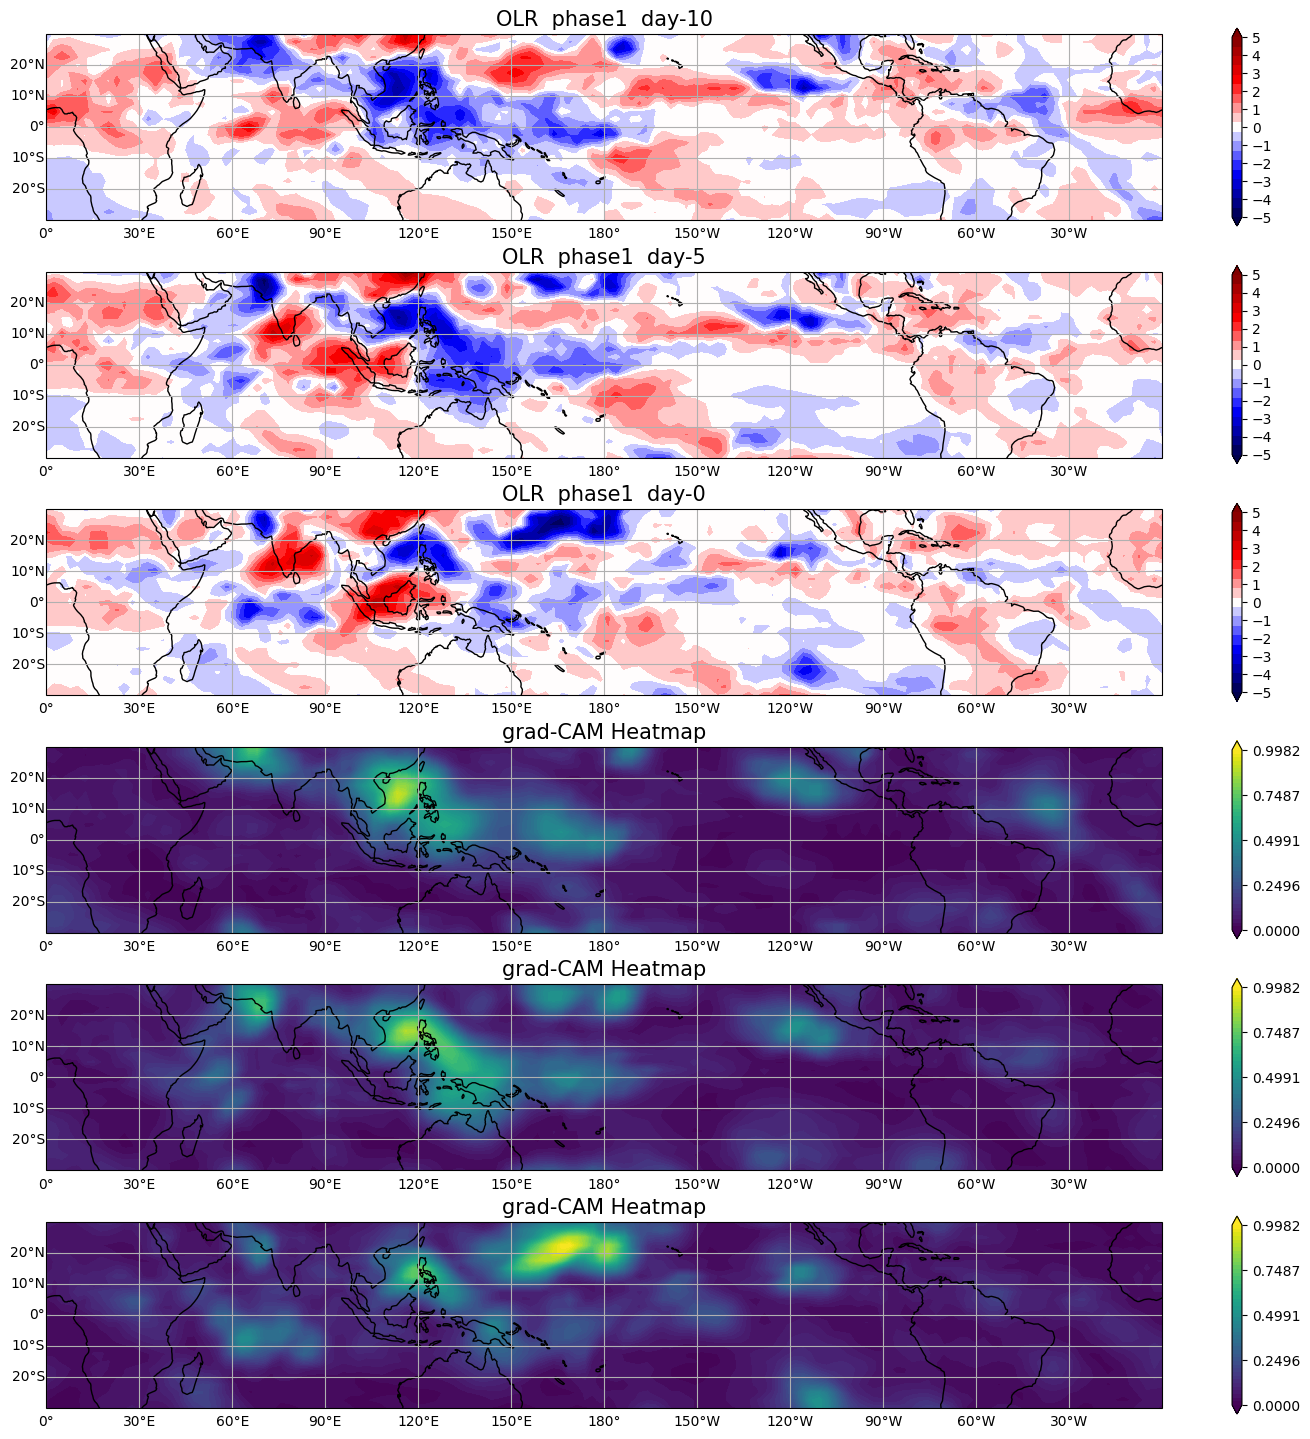

In [ ]:
fig = plt.figure(figsize=(18,18))
# NOAA生データ
lag = ['-10', '-5', '-0']
for j in range(3):
  ax=fig.add_subplot(6,1,1+j, projection=ccrs.PlateCarree(central_longitude=180))
  ax.set_extent([-180, 180, -30, 30], crs=ccrs.PlateCarree())
  gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
  gl.top_labels = False     # 上部の経度のラベルを消去
  gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 30)) # 経度線
  gl.ylocator = mticker.FixedLocator(np.arange(-30, 30, 10)) # 緯度線
  ax.coastlines()

  # NOAAデータのプロット
  lon = np.linspace(0, 360, 144)
  lat = np.linspace(30, -30, 25)
  x, y = np.meshgrid(lon-180.0, lat) # 経度、緯度データ
  cntr = ax.contourf(x, y, x_test[num,25*j:25*(j+1),:,0], np.linspace(-5, 5, num=20), cmap='seismic', extend='both')
  cbar = fig.colorbar(cntr, ticks = np.linspace(-5, 5, 11), orientation='vertical')
  ax.set_title('OLR  ' + 'phase'+ str(phase[0]) + '  day' + lag[j], fontsize=15)
  ax.axis((-180, 180, -30, 30))


  #==============
  ax=fig.add_subplot(6,1,4+j, projection=ccrs.PlateCarree(central_longitude=180))
  ax.set_extent([-180, 180, -30, 30], crs=ccrs.PlateCarree())
  gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
  gl.top_labels = False     # 上部の経度のラベルを消去
  gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 30)) # 経度線
  gl.ylocator = mticker.FixedLocator(np.arange(-30, 30, 10)) # 緯度線
  ax.coastlines()

  # grad_cam ヒートマップの可視化
  lon = np.linspace(0, 360, 144)
  lat = np.linspace(30, -30, 25)
  x, y = np.meshgrid(lon-180.0, lat) # 経度、緯度データ
  cntr = ax.contourf(x, y, output_img[25*j:25*(j+1),:], np.linspace(0, np.max(output_img)), cmap='viridis', extend='both')
  cbar = fig.colorbar(cntr, ticks = np.linspace(0, np.max(output_img), 5), orientation='vertical')
  ax.set_title('grad-CAM Heatmap', fontsize=15)
  ax.axis((-180, 180, -30, 30))
plt.show()

In [ ]:
# ヒートマップとの相関係数を考える
cor_lag10 = np.corrcoef(output_img[:25,:].flatten(), x_test[num,:25,:,0].flatten())
print(cor_lag10)
cor_lag5  = np.corrcoef(output_img[25:50,:].flatten(), x_test[num,25:50,:,0].flatten())
print(cor_lag5)
cor_lag0  = np.corrcoef(output_img[50:75,:].flatten(), x_test[num,50:75,:,0].flatten())
print(cor_lag0)

[[ 1.         -0.61381341]
 [-0.61381341  1.        ]]
[[ 1.         -0.64527516]
 [-0.64527516  1.        ]]
[[ 1.         -0.45435106]
 [-0.45435106  1.        ]]


In [ ]:
# 全テストデータに対してGrad-CAMを適用する
output_imgs = []
target_layer = 'activation_2'

for N in range(1278):
  x_image_i = x_test[N,:,:,:]
  output_img_i = grad_cam(model, x_image_i, target_layer)
  output_imgs.append(output_img_i)
  if N % 100 == 0:
    print('number = ', N)
output_imgs = np.array(output_imgs)

number =  0
number =  100
number =  200
number =  300
number =  400
number =  500
number =  600
number =  700
number =  800
number =  900
number =  1000
number =  1100
number =  1200


In [ ]:
print(output_imgs.shape)
print(y_labels.shape)

(1278, 75, 144)
(6570,)


In [ ]:
# year, month, day, PC, phase,OLR の配列とともにheat map もまとめて保存する
idx = np.where((year >= 2013) & ((month == 6) & (day > 10)| (month >= 7)))[0]   # ラグを考慮するため、6月10日からのデータである
phase = y_labels[idx]
PCs =y_pc[idx]

year = year[idx]
month = month[idx]
day = day[idx]
# shape の確認
print(phase.shape, PCs.shape, year.shape, month.shape, day.shape, output_imgs.shape, x_test.shape)

np.savez('/content/drive/MyDrive/bsiso_cnn/results/1channel_3lag_cnn_results.npz',
         year=year, month=month, day=day, phase=phase, PCs=PCs, train_OLR=x_test, heatmap=output_imgs)

(1278,) (1278, 2) (1278,) (1278,) (1278,) (1278, 75, 144) (1278, 75, 144, 1)


In [ ]:
# 以下の作業はここからスタートで構わない：
#d = np.load('/content/drive/MyDrive/bsiso_cnn/results/3channel_cnn_results.npz')
d = np.load('/content/drive/MyDrive/bsiso_cnn/results/1channel_3lag_cnn_results.npz')
year  = d['year']
month = d['month']
day   = d['day']
phase = d['phase']
PCs   = d['PCs']
heatmap = d['heatmap']


In [ ]:
# 統計量の計算
#heatmap = output_imgs
hp_mean = heatmap.mean(axis=0)
hp_std = heatmap.std(axis=0)
hp_norm = (heatmap - hp_mean) / hp_std

print(hp_norm.shape)

(1278, 75, 144)


In [ ]:
# 上側下側それぞれ2.5％切り捨て

# 1次元目に沿った値をフラット化して上側5%に該当する値を取得
percentile_highcutoff = np.percentile(hp_norm, 97.5, axis=0)
percentile_lowcutoff  = np.percentile(hp_norm, 2.5, axis=0)
print(percentile_highcutoff.shape)
# 上側5%の値を持つ要素のマスクを作成
mask_up   = hp_norm > percentile_highcutoff
mask_down = hp_norm < percentile_lowcutoff

# 上側5%の値を NaN に置き換える（もしくは除外する）
hp_norm[mask_up]    = np.nan
hp_norm[mask_down]  = np.nan
# NaNを持つ要素を除外する
print(hp_norm.shape)
hp_norm_tst = hp_norm[~np.isnan(hp_norm).any(axis=(1,2))]
print(hp_norm_tst.shape)


(25, 144)
(1278, 25, 144)
(0, 25, 144)


In [ ]:
# heat map のphaseコンポジット
phase_idx = (phase == 8)
phase_mean = np.nanmean(hp_norm[phase_idx], axis=0)
print(phase_mean.shape)

(75, 144)


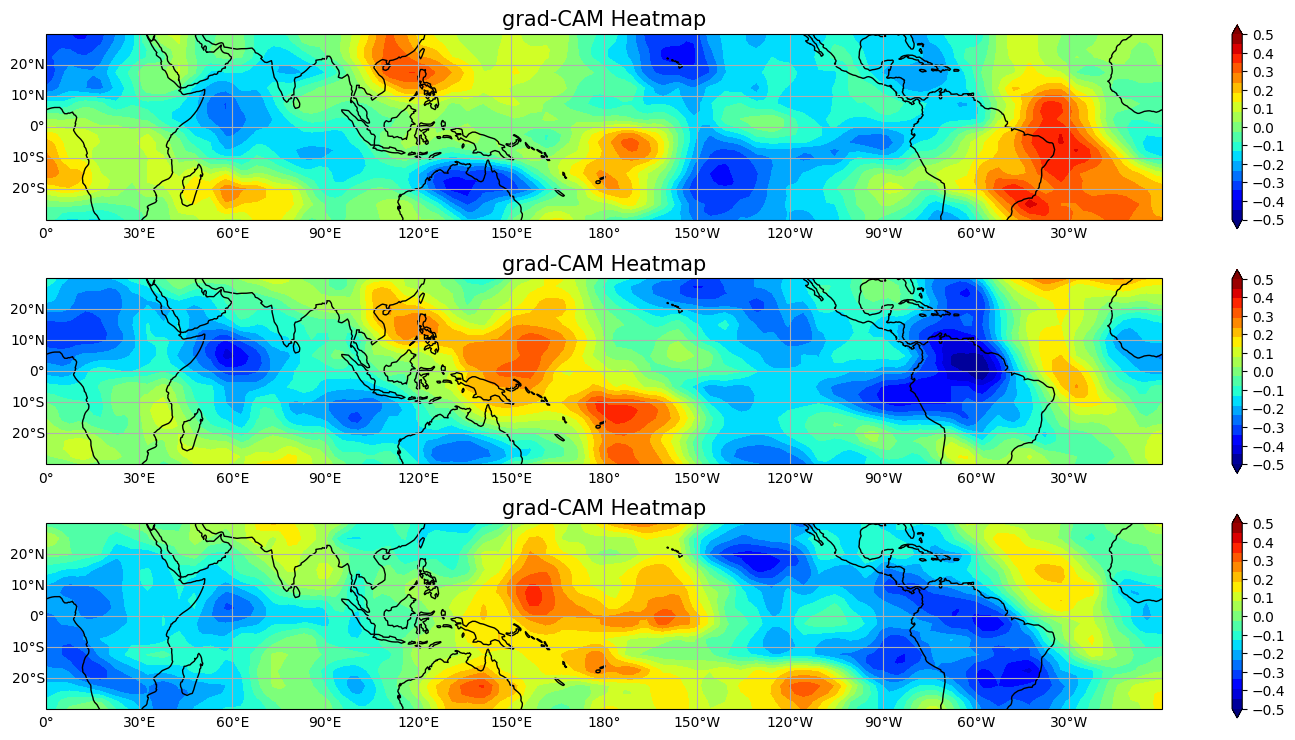

In [ ]:
fig = plt.figure(figsize=(18,9))
for l in range(3):
  ax=fig.add_subplot(3,1,l+1, projection=ccrs.PlateCarree(central_longitude=180))
  ax.set_extent([-180, 180, -30, 30], crs=ccrs.PlateCarree())
  gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
  gl.top_labels = False     # 上部の経度のラベルを消去
  gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 30)) # 経度線
  gl.ylocator = mticker.FixedLocator(np.arange(-30, 30, 10)) # 緯度線
  ax.coastlines()

  # grad_cam ヒートマップの可視化
  lon = np.linspace(0, 360, 144)
  lat = np.linspace(30, -30, 25)
  x, y = np.meshgrid(lon-180.0, lat) # 経度、緯度データ
  cntr = ax.contourf(x, y, phase_mean[25*l:25*(l+1)], np.linspace(-0.5, 0.5, 20), cmap='jet', extend='both')
  cbar = fig.colorbar(cntr, ticks = np.linspace(-0.5, 0.5, 11), orientation='vertical')
  ax.set_title('grad-CAM Heatmap', fontsize=15)
  ax.axis((-180, 180, -30, 30))
plt.show()

In [ ]:
# ヒートマップとの相関係数を考える
cor_lag10 = np.corrcoef(phase_mean[:25,:].flatten(), x_test[num,:25,:,0].flatten())
print(cor_lag10)
cor_lag5  = np.corrcoef(phase_mean[25:50,:].flatten(), x_test[num,25:50,:,0].flatten())
print(cor_lag5)
cor_lag0  = np.corrcoef(phase_mean[50:75,:].flatten(), x_test[num,50:75,:,0].flatten())
print(cor_lag0)

[[ 1.         -0.12616108]
 [-0.12616108  1.        ]]
[[ 1.         -0.18079696]
 [-0.18079696  1.        ]]
[[ 1.         -0.13157801]
 [-0.13157801  1.        ]]


(75, 144)
(75, 144)
(75, 144)
(75, 144)
(75, 144)
(75, 144)
(75, 144)
(75, 144)


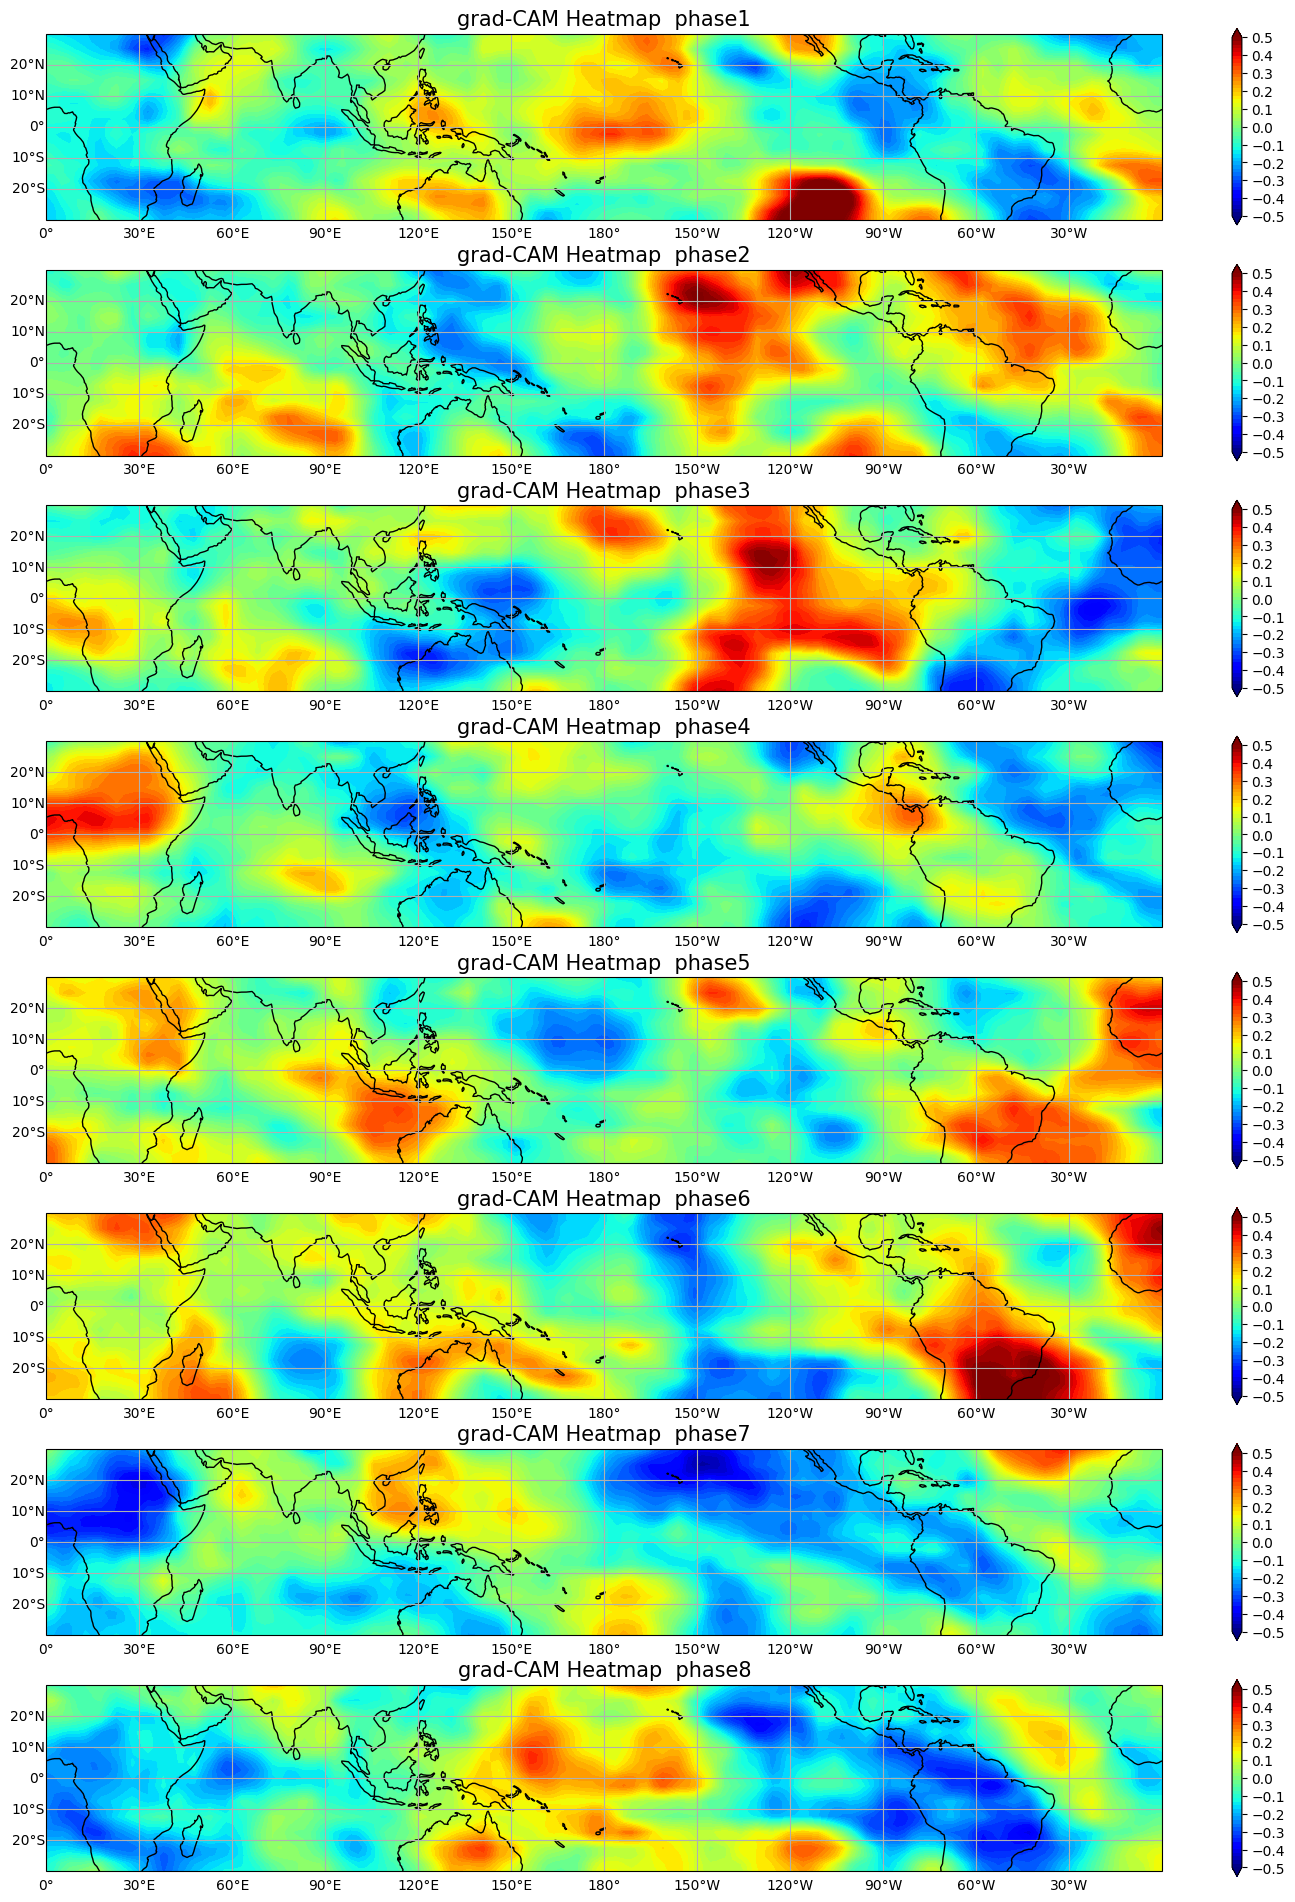

In [ ]:
# tstudent で計算し直したとき
fig = plt.figure(figsize=(18,24))
for pic in range(8):
  # heat map のphaseコンポジット
  phase_idx = (phase == pic + 1)
  phase_mean = np.nanmean(hp_norm[phase_idx], axis=0)
  print(phase_mean.shape)

  # 可視化
  ax=fig.add_subplot(8,1,pic+1, projection=ccrs.PlateCarree(central_longitude=180))
  ax.set_extent([-180, 180, -30, 30], crs=ccrs.PlateCarree())
  gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
  gl.top_labels = False     # 上部の経度のラベルを消去
  gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 30)) # 経度線
  gl.ylocator = mticker.FixedLocator(np.arange(-30, 30, 10)) # 緯度線
  ax.coastlines()

  # grad_cam ヒートマップの可視化
  lon = np.linspace(0, 360, 144)
  lat = np.linspace(30, -30, 25)
  x, y = np.meshgrid(lon-180.0, lat) # 経度、緯度データ
  cntr = ax.contourf(x, y, phase_mean[50:75,:], np.linspace(-0.5, 0.5, 50), cmap='jet', extend='both')
  cbar = fig.colorbar(cntr, ticks = np.linspace(-0.5, 0.5, 11), orientation='vertical')
  ax.set_title('grad-CAM Heatmap  phase'+ str(pic+1), fontsize=15)
  ax.axis((-180, 180, -30, 30))
plt.show()

## フェーズ別skill

In [ ]:
# =======
# phaseデータのセット           # !!! 2013/06/01 - 2021/10/31までのデータセット !!!

def phase_data(x_data, lag1, lag2):
  phase_prepro = []
  for i in range(2014, 2022):
    data_i = np.where(year == i)[0]
    phase_i = phase[data_i]
    phase_i = phase_i[lag1:phase_i.shape[0]+lag2-lead_time]
    phase_prepro.append(phase_i)
  phase_prepro = np.concatenate(phase_prepro)
  print(phase_prepro.shape)
  return phase_prepro

phase_test = phase_data(phase, 10, 0)
print(phase_test[:70])

(2532,)
[5 5 5 5 5 5 5 6 6 6 6 6 6 6 7 7 7 7 7 8 8 8 8 1 1 1 1 1 2 2 2 2 2 2 3 3 3
 4 4 5 5 5 5 6 6 6 6 6 7 7 7 7 7 8 8 8 1 1 1 2 2 2 2 2 3 3 3 3 3 3]


In [ ]:
# skill のphase コンポジットを計算する
cor_box = np.zeros((8,31))
for p in range(1,9):
  idx_ph = np.where(ph == p)[0]
  predict_ph = predict[idx_ph]
  y_test_ph = y_test[idx_ph]
  # prediction skill をリードタイムごとに出す
  # Forcast skill evaluation(COR)
  for j in range(lead_time+1):
    cor_box[p-1,j] = (np.sum(predict_ph[:,2*j] * y_test_ph[:,2*j], axis=0) + np.sum(predict_ph[:,2*j+1] * y_test_ph[:,2*j+1], axis=0)) / \
              (np.sqrt(np.sum(predict_ph[:,2*j] ** 2 + predict_ph[:,2*j+1] ** 2, axis=0)) * np.sqrt(np.sum(y_test_ph[:,2*j] ** 2 + y_test_ph[:,2*j+1] ** 2, axis=0)))
print(cor_box.shape)
#print(cor_box)

(8, 31)


<ipython-input-43-ba1305c31dbc>:6: UserWarning: The following kwargs were not used by contour: 'linestyle'
  cntr  = ax.contour(x, y, cor_box, [0.6], colors='k', linewidths=.8, linestyle='solid')


Text(0.5, 1.0, 'Correlation as a function of the phase')

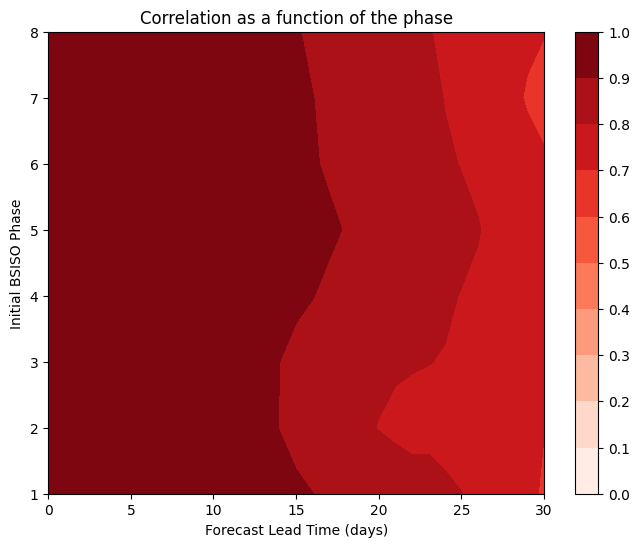

In [ ]:
# plot
fig = plt.figure(figsize=(8,6))
ax=fig.add_subplot(1,1,1)
x, y = np.meshgrid(np.arange(0,31), np.arange(1,9)) # 経度、緯度データ
cntrf = ax.contourf(x, y, cor_box, np.linspace(0, 1, num=11), cmap='Reds')
cntr  = ax.contour(x, y, cor_box, [0.6], colors='k', linewidths=.8, linestyle='solid')
cbar  = fig.colorbar(cntrf, ticks = np.linspace(0, 1, 11), orientation='vertical')
plt.xlabel('Forecast Lead Time (days)')
plt.ylabel('Initial BSISO Phase')
plt.title('Correlation as a function of the phase')

### ● AMplitude 別のスキル

In [ ]:
print(predict.shape, y_test.shape)
print(predict[:4,:2], y_test[:4,:2])
test_amp = np.zeros((1287, 30))
for t in range(30):
  test_amp[:,t] = np.sqrt(y_test[:,2*t]**2 + y_test[:,2*t+1]**2)


(1287, 60) (1287, 60)
[[-0.676523    0.7658847 ]
 [-0.699759    0.69338727]
 [-0.70836234  0.6516983 ]
 [-0.64510345  0.5473445 ]] [[-0.714  0.766]
 [-0.779  0.657]
 [-0.811  0.536]
 [-0.806  0.409]]


Text(0, 0.5, 'number of daily data')

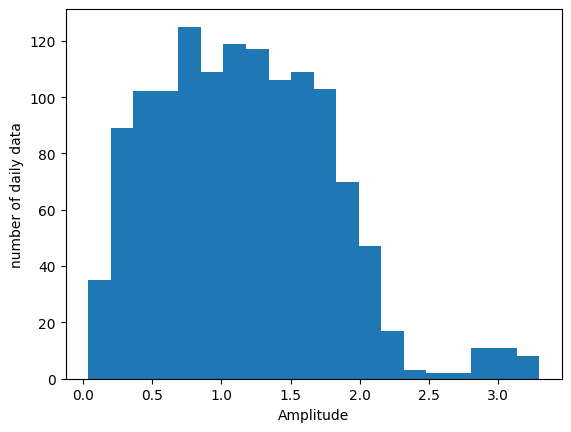

In [ ]:
plt.hist(test_amp[:,0], bins=20)
plt.xlabel('Amplitude')
plt.ylabel('number of daily data')

In [ ]:
amp_box = np.arange(0, 2.4, 0.3)
print(amp_box)
cor_box = np.zeros((8,30))
for j in amp_box:
  amp = np.where((test_amp[:,0] >= j) & (test_amp[:,0] < j + 0.3))
  y_test_amp = y_test[amp,:].reshape(-1,60)
  predict_amp = predict[amp,:].reshape(-1,60)
  #print(y_test_amp, predict_amp)
  # prediction skill をリードタイムごとに出す
  # Forcast skill evaluation(COR)
  for t in range(30):
    cor_box[j-1,t] = (np.sum(predict_amp[:,2*t] * y_test_amp[:,2*t], axis=0) + np.sum(predict_amp[:,2*t+1] * y_test_amp[:,2*t+1], axis=0)) / \
              (np.sqrt(np.sum(predict_amp[:,2*t] ** 2 + predict_amp[:,2*t+1] ** 2, axis=0)) * np.sqrt(np.sum(y_test_amp[:,2*t] ** 2 + y_test_amp[d:,2*t+1] ** 2, axis=0)))
print(cor_box)

[0.  0.3 0.6 0.9 1.2 1.5 1.8 2.1]


IndexError: ignored